In [1]:
import sys
sys.path.append('../../..')

import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras import optimizers
from deepctr.models import DeepFM
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn import preprocessing
from utils.preprocessing import read_data
import core.config as conf
import matplotlib.pyplot as plt


from utils.evaluate import calculate_ctr, compute_rce, average_precision_score

In [2]:
TARGET = 'like'

In [3]:
train = pd.read_csv(f'{conf.dataset_path}/train')
valid = pd.read_csv(f'{conf.dataset_path}/valid')
test = pd.read_csv(f'{conf.dataset_path}/test')

In [10]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels
RMV = [c for c in DONT_USE if c in train.columns]

In [11]:
y_train = train[TARGET]
X_train = train.drop(RMV, axis=1)

y_valid = valid[TARGET]
X_valid = valid.drop(RMV, axis=1)

y_test = test[TARGET]
X_test = test.drop(RMV, axis=1)

### scaling

In [12]:
 scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 
                           'engager_following_count', 'dt_dow', 'dt_hour', 'len_domains', 'creator_main_language', 'engager_main_language',
                           'engager_feature_number_of_previous_like_engagement',
                           'engager_feature_number_of_previous_reply_engagement',
                           'engager_feature_number_of_previous_retweet_engagement',
                           'engager_feature_number_of_previous_comment_engagement',
                           'number_of_engagements_positive',
                        #    'creator_feature_number_of_previous_like_engagement',
                        #    'creator_feature_number_of_previous_reply_engagement',
                        #    'creator_feature_number_of_previous_retweet_engagement',
                        #    'creator_feature_number_of_previous_comment_engagement',
                        #    'creator_number_of_engagements_positive',
                        #    'len_text_tokens',
                        #    'len_text_tokens_unique',
                        #    'cnt_mention',
                            'number_of_tweet_engagements']

In [13]:
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [14]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train[scaling_columns])
sc = standard_scaler.transform(X_train[scaling_columns])

In [15]:
X_train[scaling_columns] = pd.DataFrame(sc, columns = scaling_columns)
X_train = X_train.fillna(0)

X_valid[scaling_columns] = pd.DataFrame(sc, columns = scaling_columns)
X_valid = X_valid.fillna(0)

X_test[scaling_columns] = pd.DataFrame(sc, columns = scaling_columns)
X_test = X_test.fillna(0)

## sparse & dense features

In [18]:
X_train.columns

Index(['tweet_type', 'creator_follower_count', 'creator_following_count',
       'engager_follower_count', 'engager_following_count', 'media', 'dt_dow',
       'dt_hour', 'len_domains', 'creator_main_language',
       'engager_main_language', 'creator_and_engager_have_same_main_language',
       'is_tweet_in_creator_main_language',
       'is_tweet_in_engager_main_language',
       'engager_feature_number_of_previous_like_engagement',
       'engager_feature_number_of_previous_reply_engagement',
       'engager_feature_number_of_previous_retweet_engagement',
       'engager_feature_number_of_previous_comment_engagement',
       'number_of_engagements_positive', 'number_of_engagements_ratio_like',
       'number_of_engagements_ratio_reply',
       'number_of_engagements_ratio_retweet',
       'number_of_engagements_ratio_comment', 'number_of_tweet_engagements'],
      dtype='object')

In [19]:
X_train.head()

,tweet_type,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,media,dt_dow,dt_hour,len_domains,creator_main_language,...,engager_feature_number_of_previous_like_engagement,engager_feature_number_of_previous_reply_engagement,engager_feature_number_of_previous_retweet_engagement,engager_feature_number_of_previous_comment_engagement,number_of_engagements_positive,number_of_engagements_ratio_like,number_of_engagements_ratio_reply,number_of_engagements_ratio_retweet,number_of_engagements_ratio_comment,number_of_tweet_engagements
0,0,-0.168011,-0.103682,-0.065392,-0.180827,0,0.018588,1.182860,-0.340453,-0.058820,...,-0.352543,-0.252742,-0.216313,-0.157483,-0.384874,1.000000,0.000000,0.000000,0.000000,-0.118908
1,3,-0.152424,-0.083075,-0.053885,-0.137149,1,0.538678,-1.182958,-0.340453,-0.720478,...,-0.359098,-0.209647,-0.216313,-0.157483,-0.388705,0.800000,0.200000,0.000000,0.000000,-0.116953
2,3,-0.021888,-0.081112,0.099652,2.309918,1,0.018588,1.478588,-0.340453,0.602837,...,3.851390,-0.166552,-0.123877,0.002552,3.332522,0.991273,0.001027,0.007187,0.000513,-0.089579
3,3,-0.168009,-0.099573,-0.052077,-0.220191,4,-0.501503,-1.478685,-0.340453,-0.803185,...,0.927865,-0.080362,-0.189903,-0.157483,0.752752,0.986689,0.006656,0.006656,0.000000,-0.118908
4,3,-0.156880,-0.082370,-0.046323,0.335225,0,-1.021593,1.478588,2.558924,-0.058820,...,-0.265144,-0.080362,-0.156890,-0.157483,-0.283369,0.783333,0.066667,0.150000,0.000000,-0.097400


In [20]:
sparse_features = ['tweet_type', 'creator_main_language', 'engager_main_language', 'media']
target = ['reply', 'like', 'retweet', 'retweet_comment'] 
dense_features = [feat for feat in X_train.columns if (feat not in sparse_features) and (feat not in target)]

In [21]:
X_train[sparse_features] = X_train[sparse_features].fillna('-1', )
X_train[dense_features] = X_train[dense_features].fillna(0,)

X_valid[sparse_features] = X_valid[sparse_features].fillna('-1', )
X_valid[dense_features] = X_valid[dense_features].fillna(0,)

X_test[sparse_features] = X_test[sparse_features].fillna('-1', )
X_test[dense_features] = X_test[dense_features].fillna(0,)

In [23]:
X_train[sparse_features] = X_train[sparse_features].astype(np.float32)
X_valid[sparse_features] = X_valid[sparse_features].astype(np.float32)
X_test[sparse_features] = X_test[sparse_features].astype(np.float32)

In [24]:
X_train.head()

,tweet_type,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,media,dt_dow,dt_hour,len_domains,creator_main_language,...,engager_feature_number_of_previous_like_engagement,engager_feature_number_of_previous_reply_engagement,engager_feature_number_of_previous_retweet_engagement,engager_feature_number_of_previous_comment_engagement,number_of_engagements_positive,number_of_engagements_ratio_like,number_of_engagements_ratio_reply,number_of_engagements_ratio_retweet,number_of_engagements_ratio_comment,number_of_tweet_engagements
0,0.0,-0.168011,-0.103682,-0.065392,-0.180827,0.0,0.018588,1.182860,-0.340453,-0.058820,...,-0.352543,-0.252742,-0.216313,-0.157483,-0.384874,1.000000,0.000000,0.000000,0.000000,-0.118908
1,3.0,-0.152424,-0.083075,-0.053885,-0.137149,1.0,0.538678,-1.182958,-0.340453,-0.720478,...,-0.359098,-0.209647,-0.216313,-0.157483,-0.388705,0.800000,0.200000,0.000000,0.000000,-0.116953
2,3.0,-0.021888,-0.081112,0.099652,2.309918,1.0,0.018588,1.478588,-0.340453,0.602837,...,3.851390,-0.166552,-0.123877,0.002552,3.332522,0.991273,0.001027,0.007187,0.000513,-0.089579
3,3.0,-0.168009,-0.099573,-0.052077,-0.220191,4.0,-0.501503,-1.478685,-0.340453,-0.803185,...,0.927865,-0.080362,-0.189903,-0.157483,0.752752,0.986689,0.006656,0.006656,0.000000,-0.118908
4,3.0,-0.156880,-0.082370,-0.046323,0.335225,0.0,-1.021593,1.478588,2.558924,-0.058820,...,-0.265144,-0.080362,-0.156890,-0.157483,-0.283369,0.783333,0.066667,0.150000,0.000000,-0.097400


## preprocessing

In [25]:
for feat in sparse_features :
    lbe = LabelEncoder()
    X_train[feat] = lbe.fit_transform(X_train[feat])
    X_valid[feat] = lbe.fit_transform(X_valid[feat])
    X_test[feat] = lbe.fit_transform(X_test[feat])

In [27]:
mms = MinMaxScaler(feature_range = (0, 1))

X_train[dense_features] = mms.fit_transform(X_train[dense_features])
X_valid[dense_features] = mms.fit_transform(X_valid[dense_features])
X_test[dense_features] = mms.fit_transform(X_test[dense_features])

In [28]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size = X_train[feat].max() +1, embedding_dim = 4) for feat in sparse_features]  + [DenseFeat(feat, 1,) for feat in dense_features]

In [29]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [30]:
train_model_input = {name:X_train[name].values for name in feature_names}
valid_model_input = {name:X_valid[name].values for name in feature_names}
test_model_input = {name:X_test[name].values for name in feature_names}

## Model

In [49]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task = 'binary')


In [53]:
model.compile("adam", "binary_crossentropy", 
             metrics = ['binary_crossentropy'])

In [54]:
history = model.fit(train_model_input, y_train.values,
                    batch_size = 128,
                    validation_data = (valid_model_input, y_valid.values),
                    epochs = 10,
                    verbose = 1,
                    validation_split = 0.2,)

Epoch 1/10
27101/27101 [==============================] - 42s 2ms/step - loss: 0.4879 - binary_crossentropy: 0.4879 - val_loss: 0.0796 - val_binary_crossentropy: 0.0796
Epoch 2/10
27101/27101 [==============================] - 41s 2ms/step - loss: 0.4656 - binary_crossentropy: 0.4656 - val_loss: 0.1972 - val_binary_crossentropy: 0.1971
Epoch 3/10
27101/27101 [==============================] - 41s 2ms/step - loss: 0.4653 - binary_crossentropy: 0.4652 - val_loss: 0.6603 - val_binary_crossentropy: 0.6602
Epoch 4/10
27101/27101 [==============================] - 41s 2ms/step - loss: 0.4452 - binary_crossentropy: 0.4451 - val_loss: 0.0267 - val_binary_crossentropy: 0.0265
Epoch 5/10
27101/27101 [==============================] - 41s 2ms/step - loss: 0.4524 - binary_crossentropy: 0.4522 - val_loss: 0.0508 - val_binary_crossentropy: 0.0507
Epoch 6/10
27101/27101 [==============================] - 41s 2ms/step - loss: 0.4523 - binary_crossentropy: 0.4521 - val_loss: 0.0830 - val_binary_crossen

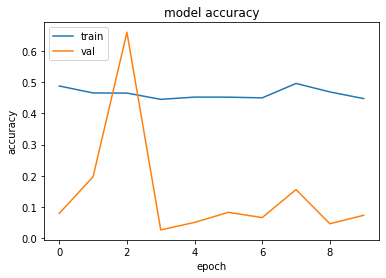

In [55]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## evaluate

In [71]:
pred = model.predict(train_model_input, batch_size = 256)

In [65]:
len(pred)

854134

In [66]:
pred

array([[0.08006516],
       [0.33575344],
       [0.08475602],
       ...,
       [0.6995398 ],
       [0.5632644 ],
       [0.7351638 ]], dtype=float32)

In [67]:
pred

array([[0.08006516],
       [0.33575344],
       [0.08475602],
       ...,
       [0.6995398 ],
       [0.5632644 ],
       [0.7351638 ]], dtype=float32)

In [72]:
rce = compute_rce(pred.reshape(-1).astype(np.float64), y_train.astype(np.float64))
rce

45.436334486108024

In [73]:
average_precision_score(y_train, pred)

0.8368149631004683